In [35]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("http://minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv")
df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


In [3]:
# 後の分析用にchannelをonehotに変換
df = pd.concat([df, pd.get_dummies(df["channel"], drop_first=True)], axis=1)
df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,Phone,Web
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0,1,0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0,0,1
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0,0,1
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0,0,1
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0,0,1


In [4]:
# バイアスデータの作成

# 男性向けメールが配信されたユーザにのみ限定
male_df = df.query(" segment!= 'Womens E-Mail' ").copy()
male_df["treatment"] = (male_df["segment"]=="Mens E-Mail").astype(int)

# treatment==0の行は購入意欲のあるユーザを抽選対象にする
male_df["obs_rate_c"] = 1
male_df["obs_rate_c"] = male_df["obs_rate_c"].mask(((male_df["recency"]<6) | (male_df["history"]>300) | (male_df["channel"]=="Multichannel")), 0.5)
# treatment==1の行は購入意欲のないユーザを抽選対象にする
male_df["obs_rate_t"] = 0.5
male_df["obs_rate_t"] = male_df["obs_rate_t"].mask(((male_df["recency"]<6) | (male_df["history"]>300) | (male_df["channel"]=="Multichannel")), 1)

np.random.seed(2)
n = len(male_df)
male_df["random_number"] = np.random.rand(n)
biased_data = male_df.query(" (treatment==0 & random_number<obs_rate_c) | (treatment==1 & random_number<obs_rate_t)")

### 傾向スコアマッチングで効果量を求める

In [5]:
y = biased_data[["treatment"]]
X = biased_data[["history", "recency", "Phone", "Web"]]
X = sm.add_constant(X) # 切片あり

# 傾向スコアを算出する学習器を作成
model = LogisticRegression(random_state=2).fit(X, y)
ps_score = model.predict_proba(X)[:, 1] # 確率を出力

In [6]:
# 全体の傾向スコアの標準偏差 * 0.2をしきい値とする
threshold = ps_score.std() * 0.2
threshold

0.024965531505406004

In [7]:
len(ps_score), len(biased_data)

(31896, 31896)

In [9]:
#data = pd.DataFrame({"treatment":biased_data["treatment"].to_numpy(), "ps_score":ps_score, "spend":biased_data["spend"].to_numpy()})
biased_data["ps_score"] = ps_score
typeA = biased_data.query(" treatment==1 ")
typeB = biased_data.query(" treatment==0 ")

Rのmatchitのデフォルトのパラメータだと
- 傾向スコアの算出方法：ロジスティック回帰
- マッチング方法：NearestNeighbors
- m.order："largest"(重複があった場合、より距離の近いものがマッチングする？)  
これの15ページ  
https://cran.r-project.org/web/packages/MatchIt/MatchIt.pdf

In [10]:
typeA_copy = typeA.copy()
typeB_copy = typeB.copy()
resultA = np.array([])
resultB = np.array([])

while True:
    # マッチング
    typeA_ps_score = typeA_copy["ps_score"].to_numpy().reshape(-1, 1)
    typeB_ps_score = typeB_copy["ps_score"].to_numpy().reshape(-1, 1)
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(typeA_ps_score)
    dist, idx = neigh.kneighbors(typeB_ps_score, 1)
    
    # マッチングが重複した場合は、より距離が近いtypeBを採用する
    matched_data = pd.DataFrame({"dist":dist.reshape(-1, ), "idx":idx.reshape(-1, )})\
                    .sort_values(['idx', 'dist'])\
                    .drop_duplicates(subset="idx")\
                    .query(" dist < @threshold ")
    if len(matched_data) == 0:
        break
    
    matched_typeA_idx = matched_data.idx.to_numpy() # typeAの中でマッチング成立した人のindex
    matched_typeB_idx = matched_data.index.to_numpy() # typeBの中でマッチング成立した人のindex
    resultA = np.append(resultA, typeA_copy.index[matched_typeA_idx].to_numpy())
    resultB = np.append(resultB, typeB_copy.index[matched_typeB_idx].to_numpy()) 
    typeA_copy = typeA_copy.drop(typeA_copy.index[matched_typeA_idx]) # typeAの中でマッチングできなかった人を残す
    typeB_copy = typeB_copy.drop(typeB_copy.index[matched_typeB_idx]) # typeBの中でマッチングできなかった人を残す
    
resultA = resultA.astype(int)
resultB = resultB.astype(int)

In [21]:
df_near = pd.concat([typeA.loc[resultA], typeB.loc[resultB]])

# ATTを推定
y = df_near[["spend"]]
x = df_near[["treatment"]]
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()

In [22]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  spend   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     17.04
Date:                Thu, 11 Aug 2022   Prob (F-statistic):           3.68e-05
Time:                        09:22:27   Log-Likelihood:                -95420.
No. Observations:               23086   AIC:                         1.908e+05
Df Residuals:                   23084   BIC:                         1.909e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5989      0.140      4.263      0.000       0.323       0.874
treatment      0.8202      0.199      4.128      0.000       0.431       1.210
==============================================================================
Omnibus:                    52395.892   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        314846358.136
Skew:                          21.935   Prob(JB):                         0.00
Kurtosis:                     573.427   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 標準化平均誤差(ASAM)

In [41]:
cols = ["recency", "history", "Phone", "Web"]
treated = (df_near.query(" treatment==1 ")[cols].mean() - df_near.query(" treatment==0 ")[cols].mean()) / df_near[cols].std()
untreated = (biased_data.query(" treatment==1 ")[cols].mean() - biased_data.query(" treatment==0 ")[cols].mean()) / biased_data[cols].std()

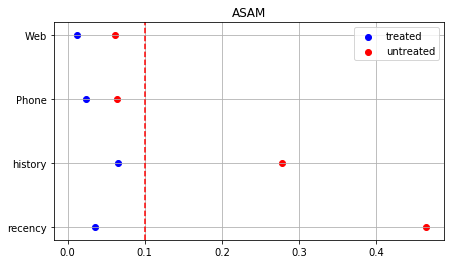

In [55]:
fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot(111)
ax.scatter(x=treated.abs().to_numpy(), y=cols, color="blue", label="treated")
ax.scatter(x=untreated.abs().to_numpy(), y=cols, color="red", label="untreated")
ax.axvline(0.1, color='red', linestyle="--") 
ax.set_title("ASAM")
plt.legend()
plt.grid()
plt.show()
plt.close()

In [39]:
treated

recency   -0.465193
history    0.278187
Phone     -0.064421
Web       -0.061160
dtype: float64

In [40]:
untreated

recency    0.035652
history    0.065833
Phone     -0.023943
Web       -0.012720
dtype: float64